# Part 1: MDS & ISOmap

We begin by loading the distance matrix from the provided distances.csv file, which contains pairwise distances between Iran cities.

In [9]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap, trustworthiness
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
import seaborn as sns

df = pd.read_csv('distances.csv', index_col=0)
distance_matrix = df.to_numpy()
cities = df.index.to_list()
print("Distance matrix shape:", distance_matrix.shape)


Distance matrix shape: (31, 31)


**Implementing ISOmap Algorithm**

We implement the ISOmap algorithm step-by-step:

Step 1: Neighborhood Graph Construction: For each city, find its k nearest neighbors and construct an adjacency matrix.

Step 2: Geodesic Distance Calculation: Use the Floyd-Warshall algorithm to
compute the shortest path distances between all pairs of cities.

Step 3: Multidimensional Scaling (MDS): Apply Classical MDS to the geodesic distance matrix to obtain 2D coordinates.

In [10]:
def construct_neighborhood_graph(distances, k=4):
    n = distances.shape[0]
    adj_matrix = np.full((n, n), np.inf)
    for i in range(n):
        adj_matrix[i, i] = 0
        nearest_indices = np.argsort(distances[i])[:k+1]
        for j in nearest_indices:
            adj_matrix[i, j] = distances[i, j]
    return adj_matrix

def floyd_warshall(adj_matrix):
    n = adj_matrix.shape[0]
    geo_dist = adj_matrix.copy()
    for k in range(n):
        for i in range(n):
            for j in range(n):
                if geo_dist[i, j] > geo_dist[i, k] + geo_dist[k, j]:
                    geo_dist[i, j] = geo_dist[i, k] + geo_dist[k, j]
    return geo_dist

def classical_mds(geo_dist):
    n = geo_dist.shape[0]
    D_sq = geo_dist ** 2
    J = np.eye(n) - (1/n) * np.ones((n, n))
    B = -0.5 * J @ D_sq @ J
    eigvals, eigvecs = np.linalg.eigh(B)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    top_eigvals = np.diag(np.sqrt(eigvals[:2]))
    top_eigvecs = eigvecs[:, :2]
    coords = top_eigvecs @ top_eigvals
    return coords

def rotate_coords(coords_aligned, angle_degrees):
    angle_radians = np.radians(angle_degrees)

    rotation_matrix = np.array([
        [np.cos(angle_radians), -np.sin(angle_radians)],
        [np.sin(angle_radians), np.cos(angle_radians)]
    ])

    rotated_coords = coords_aligned @ rotation_matrix.T

    return rotated_coords

k = 4
adj_matrix = construct_neighborhood_graph(distance_matrix, k)
geo_dist = floyd_warshall(adj_matrix)
coords = classical_mds(geo_dist)

**Visualize Map from Custom ISOmap**

We plot the 2D coordinates obtained from the custom ISOmap implementation and apply transformations to align the map with Iran's geography.

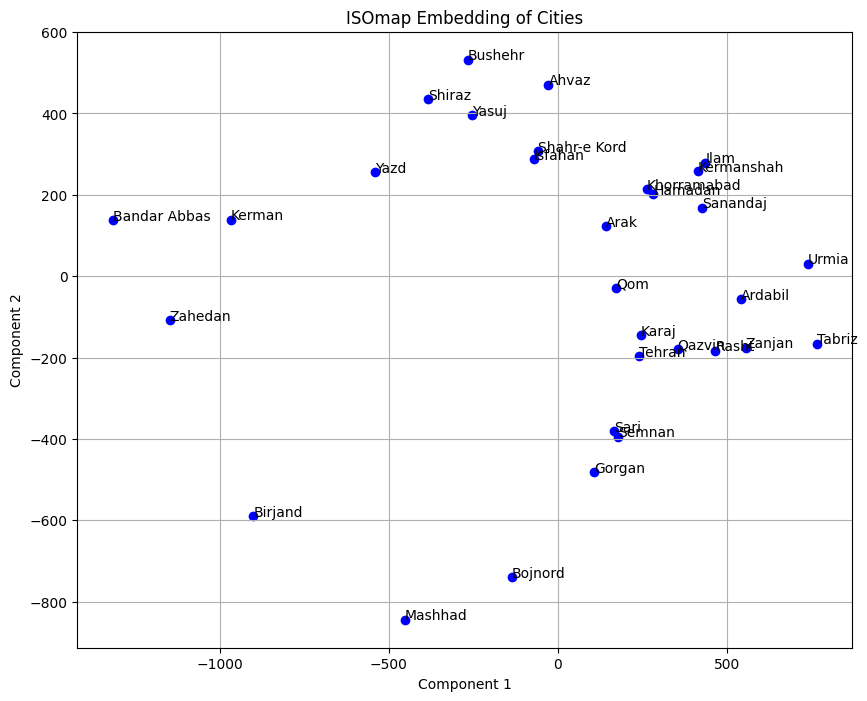

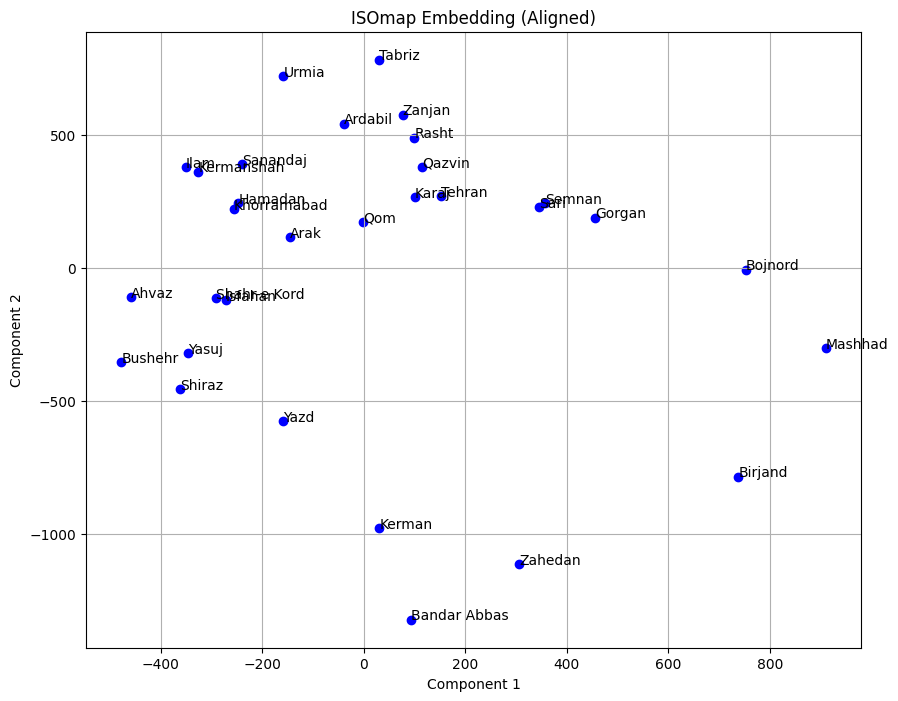

In [13]:
plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], c='blue')
for i, city in enumerate(cities):
    plt.annotate(city, (coords[i, 0], coords[i, 1]))
plt.title("ISOmap Embedding of Cities")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.savefig('isomap.png')

coords_aligned = coords.copy()
coords_aligned = rotate_coords(coords_aligned, 100)

plt.figure(figsize=(10, 8))
plt.scatter(coords_aligned[:, 0], coords_aligned[:, 1], c='blue')
for i, city in enumerate(cities):
    plt.annotate(city, (coords_aligned[i, 0], coords_aligned[i, 1]))
plt.title("ISOmap Embedding (Aligned)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.savefig('isomap_aligned.png')

**Scikit-learn's ISOmap**

We use scikit-learn's Isomap to compute the 2D embedding and compare it with our custom implementation.

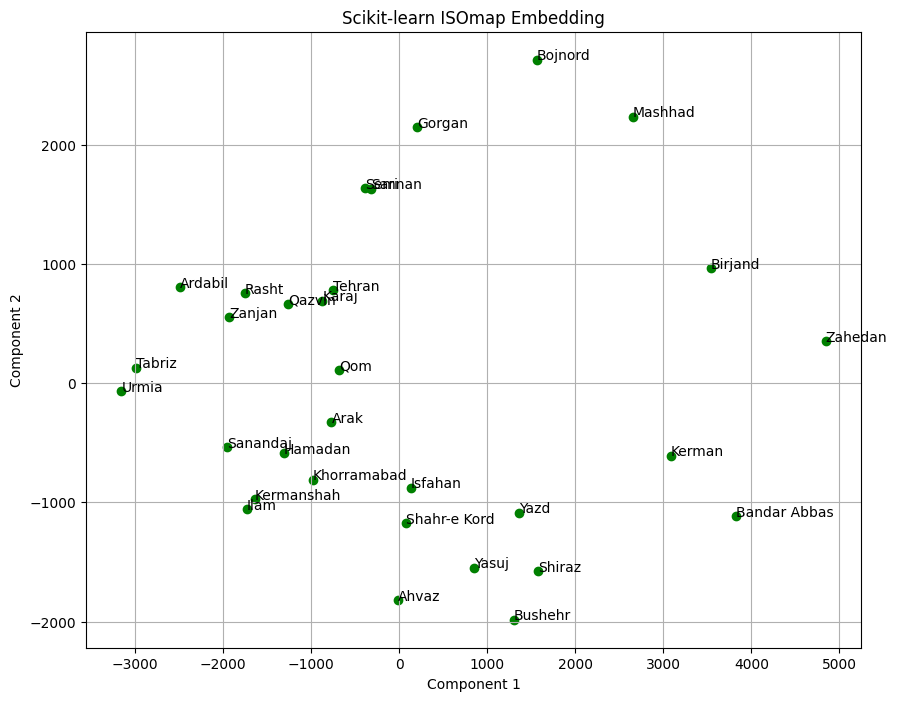

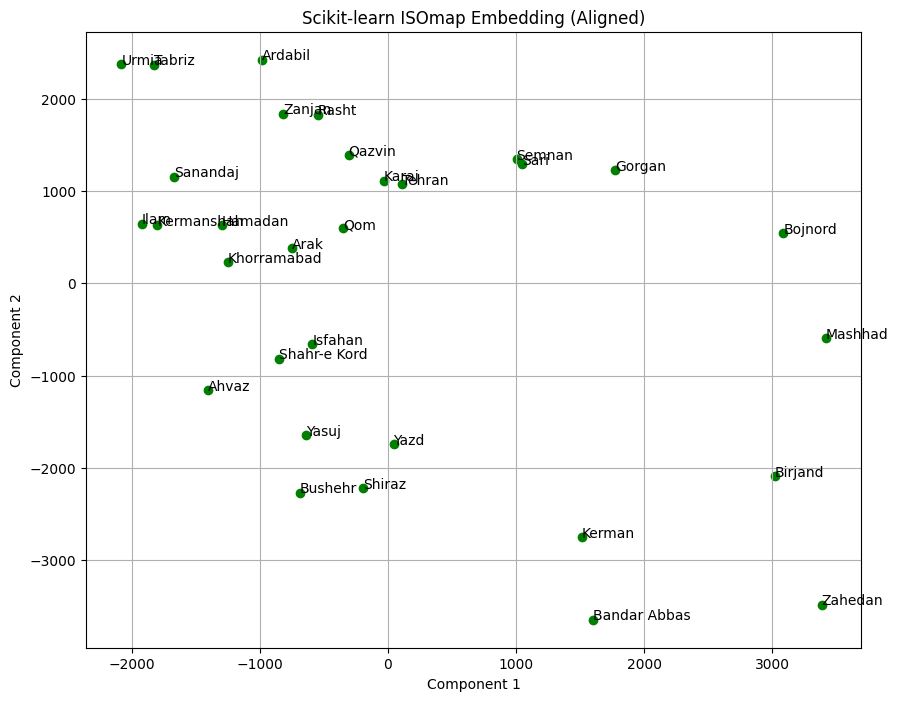

In [18]:
isomap_sk = Isomap(n_components=2, n_neighbors=k)
coords_sk = isomap_sk.fit_transform(distance_matrix)

plt.figure(figsize=(10, 8))
plt.scatter(coords_sk[:, 0], coords_sk[:, 1], c='green')
for i, city in enumerate(cities):
    plt.annotate(city, (coords_sk[i, 0], coords_sk[i, 1]))
plt.title("Scikit-learn ISOmap Embedding")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.savefig('sklearn_isomap.png')

coords_sk_aligned = coords_sk.copy()
coords_sk_aligned = rotate_coords(coords_sk_aligned, -50)

plt.figure(figsize=(10, 8))
plt.scatter(coords_sk_aligned[:, 0], coords_sk_aligned[:, 1], c='green')
for i, city in enumerate(cities):
    plt.annotate(city, (coords_sk_aligned[i, 0], coords_sk_aligned[i, 1]))
plt.title("Scikit-learn ISOmap Embedding (Aligned)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.savefig('sklearn_isomap_aligned.png')

# Part 2: Dimension Reduction on MNIST

**Load and Preprocess MNIST Data**

We load a subset of the MNIST dataset (5000 samples) and flatten the images into 1D vectors.

In [19]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
n_samples = 5000
indices = np.random.choice(X.shape[0], n_samples, replace=False)
X_subset = X[indices]
y_subset = y[indices].astype(int)
print("MNIST subset shape:", X_subset.shape)

MNIST subset shape: (5000, 784)


**Apply PCA and t-SNE**

We apply PCA and t-SNE to reduce the dimensionality of the MNIST data to 2D and visualize the embeddings.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


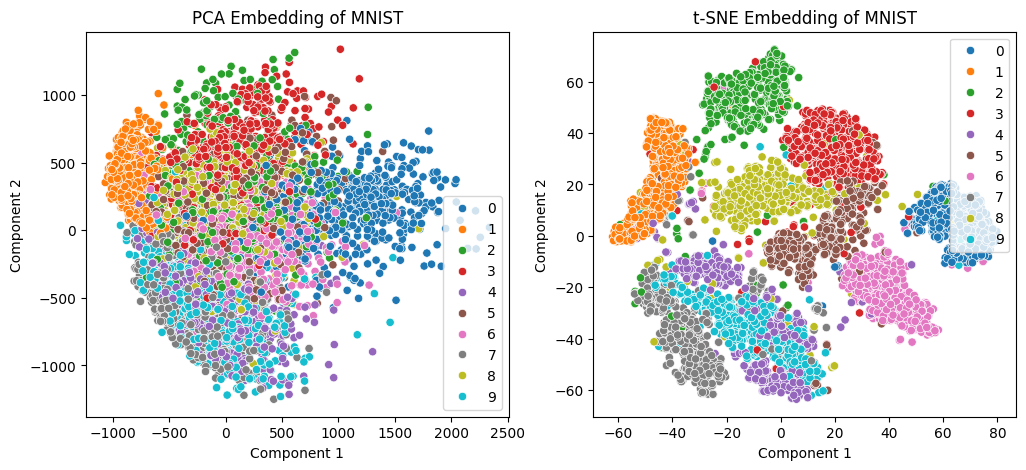

In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_subset)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_subset)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_subset, palette='tab10', legend='full')
plt.title("PCA Embedding of MNIST")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_subset, palette='tab10', legend='full')
plt.title("t-SNE Embedding of MNIST")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.savefig('mnist_embeddings.png')

**Trustworthiness**

Trustworthiness measures how well the local structure (neighborhoods) of the high-dimensional data is preserved in the low-dimensional embedding. It calculates the proportion of nearest neighbors in the original space that remain close in the reduced space. The metric ranges from 0 to 1, with 1 indicating perfect preservation of local structure.


**Evaluate PCA and t-SNE with Trustworthiness**

We calculate the Trustworthiness score for both PCA and t-SNE embeddings.

In [21]:
trust_pca = trustworthiness(X_subset, X_pca, n_neighbors=10)
trust_tsne = trustworthiness(X_subset, X_tsne, n_neighbors=10)
print(f"Trustworthiness PCA: {trust_pca:.3f}")
print(f"Trustworthiness t-SNE: {trust_tsne:.3f}")

Trustworthiness PCA: 0.737
Trustworthiness t-SNE: 0.980


**Investigate Perplexity in t-SNE**

We vary the perplexity parameter in t-SNE and observe its effect on the KL divergence.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarnin

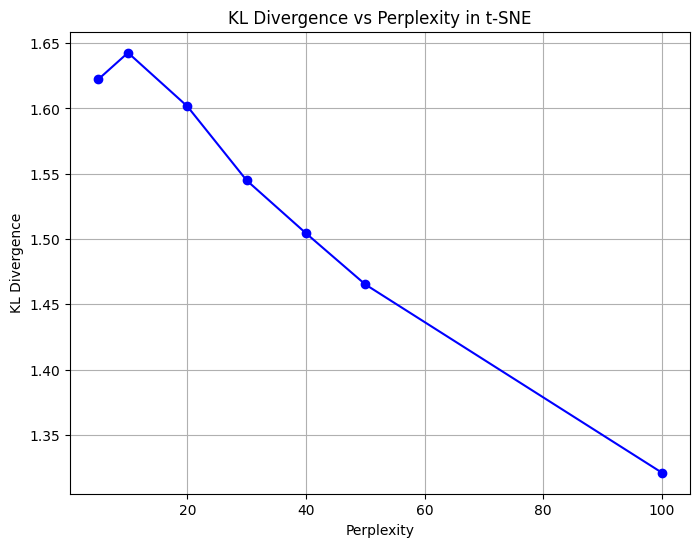

In [22]:
perplexities = [5, 10, 20, 30, 40, 50, 100]
kl_divergences = []

for perp in perplexities:
    tsne_temp = TSNE(n_components=2, perplexity=perp, max_iter=1000, random_state=42)
    X_temp = tsne_temp.fit_transform(X_subset)
    kl_divergences.append(tsne_temp.kl_divergence_)

plt.figure(figsize=(8, 6))
plt.plot(perplexities, kl_divergences, 'bo-')
plt.title("KL Divergence vs Perplexity in t-SNE")
plt.xlabel("Perplexity")
plt.ylabel("KL Divergence")
plt.grid(True)
plt.savefig('tsne_perplexity.png')